# Decision tree, KNN, and RandomForest demo
2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [1]:
using PyCall, PyPlot
plt = pyimport("matplotlib.pyplot")
SkTree = pyimport("sklearn.tree")
include("__init__.jl")
SkNeighbors = pyimport("sklearn.neighbors")
SkEnsemble = pyimport("sklearn.ensemble")

PyObject <module 'sklearn.ensemble' from 'C:\\Users\\jasonsyc.STUDENTS.000\\.julia\\conda\\3\\lib\\site-packages\\sklearn\\ensemble\\__init__.py'>

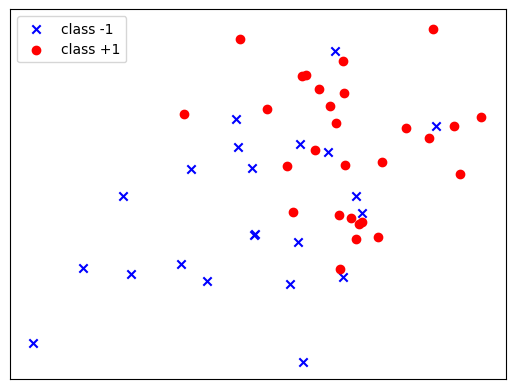

In [2]:
# make up some fake data

N = 50
X = randn(N,2)
y = rand([-1,+1],N)
X[y.>0,1] .+= 1
X[y.>0,2] .+= 1

plt.scatter(X[y.<0,1], X[y.<0,2], color="b", marker="x", label="class -1")
plt.scatter(X[y.>0,1], X[y.>0,2], color="r", marker="o",  label="class +1")
plt.tick_params(axis="both", which="both", bottom=false, left=false, labelbottom=false, labelleft=false) # remove ticks
plt.legend(loc="best");

## Decision trees

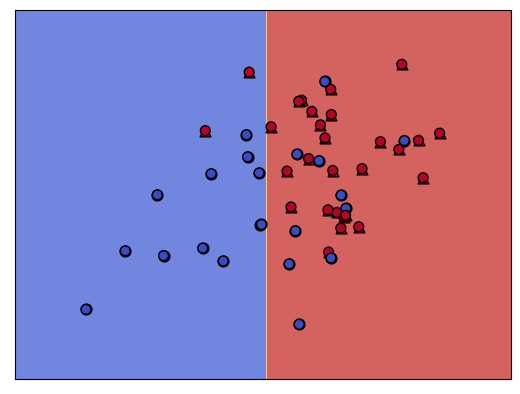

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000032F63438>

In [3]:
dt = SkTree.DecisionTreeClassifier(max_depth=1)
dt.fit(X,y)
plot_classifier(X, y, dt)

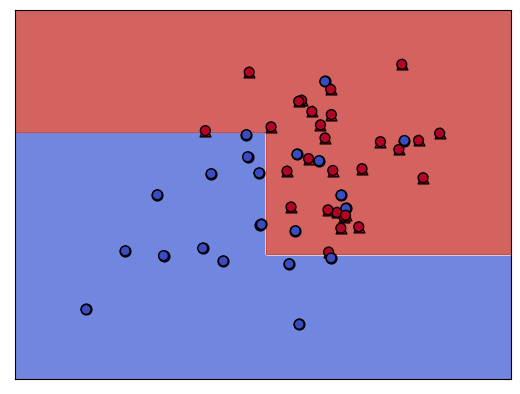

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000333599B0>

In [4]:
dt = SkTree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,y)
plot_classifier(X, y, dt)

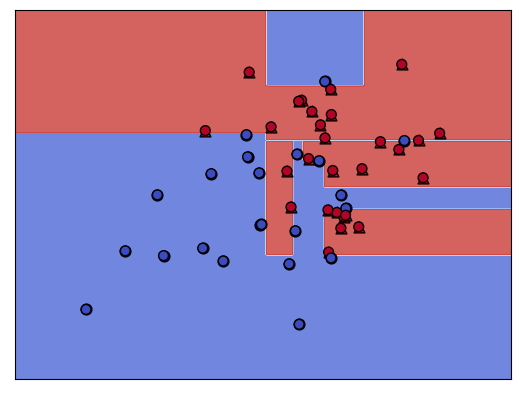

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000033359358>

In [5]:
dt = SkTree.DecisionTreeClassifier()
dt.fit(X,y)
plot_classifier(X, y, dt)


## KNN

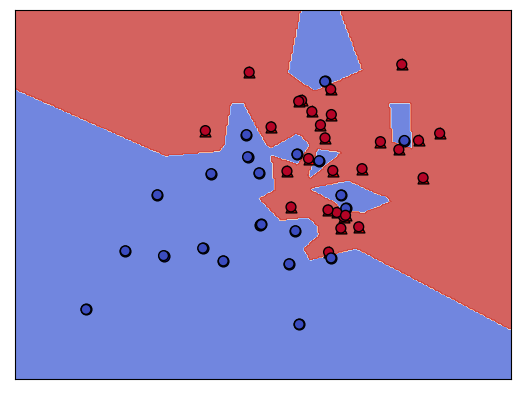

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000347209B0>

In [6]:
nn = SkNeighbors.KNeighborsClassifier(n_neighbors=1)
nn.fit(X,y)
plot_classifier(X, y, nn)

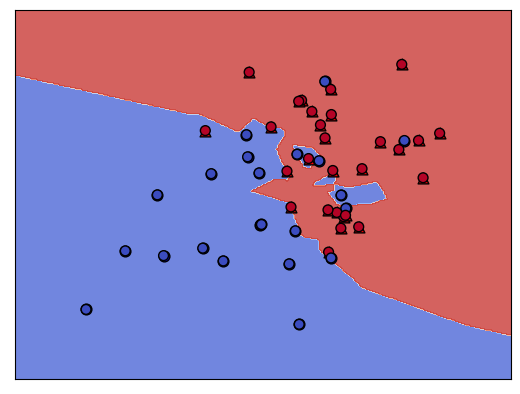

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000348F58D0>

In [7]:
nn = SkNeighbors.KNeighborsClassifier(n_neighbors=3)
nn.fit(X,y)
plot_classifier(X, y, nn)

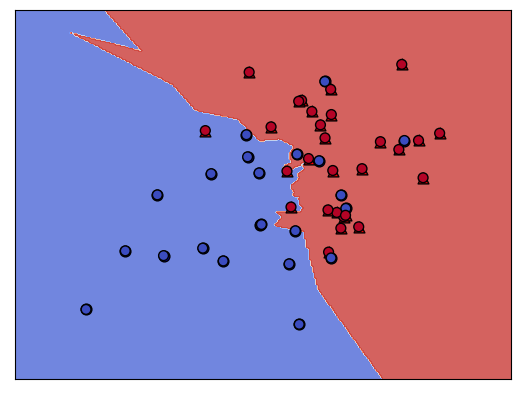

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000034960898>

In [8]:
nn = SkNeighbors.KNeighborsClassifier(n_neighbors=10)
nn.fit(X,y)
plot_classifier(X, y, nn)

## Random Forests

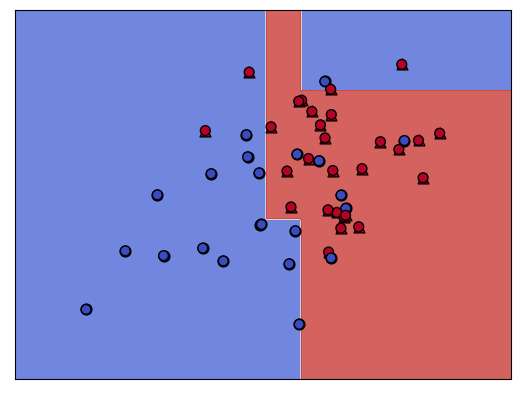

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000001FAE208>

In [9]:
rf = SkEnsemble.RandomForestClassifier(n_estimators=1)
rf.fit(X,y)
plot_classifier(X, y, rf)

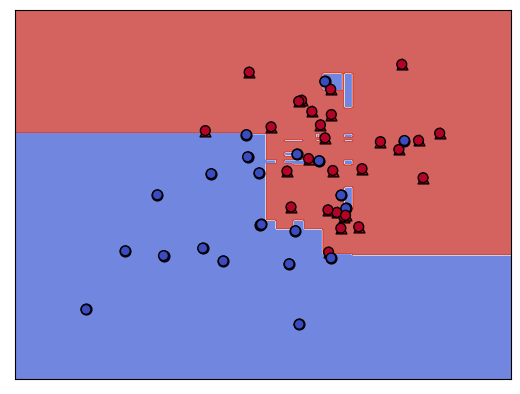

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x000000000213CCF8>

In [10]:
rf = SkEnsemble.RandomForestClassifier(n_estimators=5)
rf.fit(X,y)
plot_classifier(X, y, rf)

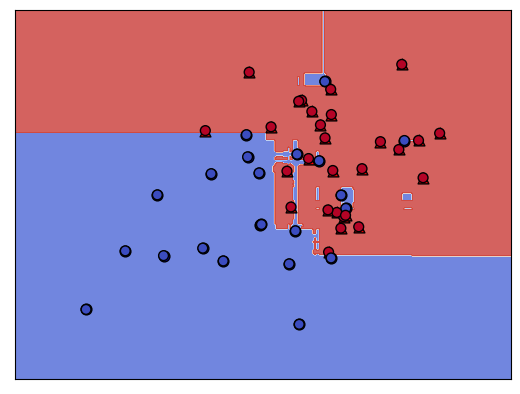

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000021B1BE0>

In [11]:
rf = SkEnsemble.RandomForestClassifier(n_estimators=50)
rf.fit(X,y)
plot_classifier(X, y, rf)

### Averaging KNN, Decision Tree, Random Forest

- The next cell will be slow the first time you run it, as it needs to download the data set (internet connection needed).


In [12]:
SkDatasets = pyimport("sklearn.datasets")

# load the newsgroups data
train = SkDatasets.fetch_20newsgroups_vectorized(subset="train")
X_train = train["data"]
y_train = train["target"]

test = SkDatasets.fetch_20newsgroups_vectorized(subset="test")
X_test = test["data"]
y_test = test["target"];

In [13]:
println("n = ", X_train.shape[1])
println("d = ", X_train.shape[2])
println("t = ", X_test.shape[1])
num_classes = length(unique(y_train))
println("number of classes = ", num_classes)

n = 11314
d = 130107
t = 7532
number of classes = 20


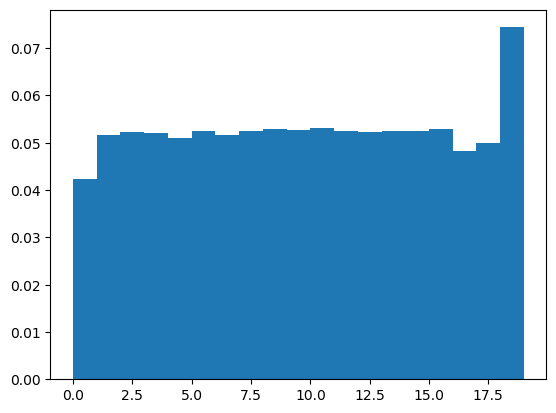

In [14]:
# check the uniformity of the training labels
plt.hist(y_train, density=true, bins=sort(unique(y_train)));

Ok, they aren't perfectly uniform but the situation isn't too bad either.

In [15]:
function print_errs(model)
    train_err = 1-model.score(X_train, y_train)
    test_err  = 1-model.score(X_test,  y_test)

    println("Train error: ", train_err)
    println("Test  error: ", test_err)
end

print_errs (generic function with 1 method)

In [16]:
@time begin

    dt = SkTree.DecisionTreeClassifier()
    dt.fit(X_train, y_train)

    print_errs(dt)
end

Train error: 8.838607035532853e-5
Test  error: 0.4401221455124801
 27.190277 seconds (293.56 k allocations: 14.688 MiB, 0.03% gc time)


In [17]:
@time begin

    rf = SkEnsemble.RandomForestClassifier()
    rf.fit(X_train, y_train)

    print_errs(rf)
end

Train error: 0.001502563196040252
Test  error: 0.4387944768985661
  6.668999 seconds (190 allocations: 7.031 KiB)


C:\Users\jasonsyc.STUDENTS.000\.julia\conda\3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Above: ironically, the random forest trains faster than the decision tree, presumably because it's only considering $\sqrt{d}$ features per split and $d$ is very large here.

In [18]:
@time begin

    knn = SkNeighbors.KNeighborsClassifier()
    knn.fit(X_train, y_train)

    print_errs(knn)
end

Train error: 0.20867951210889168
Test  error: 0.5916091343600638
 27.995992 seconds (142 allocations: 5.000 KiB)


In [19]:
# run this cell again because Jupyter is buggy :(
knn = SkNeighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

print_errs(knn)

Train error: 0.20867951210889168
Test  error: 0.5916091343600638


In [21]:
classifiers = Dict(
    "decision tree" => dt,
    "random forest" => rf,
    "KNN"           => knn
)

ensemble = SkEnsemble.VotingClassifier(collect(classifiers))
ensemble.fit(X_train, y_train)

print_errs(ensemble)

Train error: 0.0005303164221318601
Test  error: 0.41954328199681357


Overall the results here aren't that amazing. And yet it's cool that the ensemble is better than all 3 individual classifiers.

## (bonus) XGBoost

- This requires some extra installation: `conda install py-xgboost` worked for me.
- This code takes several minutes to run (for me at least).
- The following code cell is a hack to make XGBoost work on macOS, see https://github.com/dmlc/xgboost/issues/1715

In [26]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

┌ Warning: `setindex!(o::PyObject, v, s::Union{Symbol, AbstractString})` is deprecated in favor of `setproperty!(o, s, v)`.
│   caller = top-level scope at In[26]:2
└ @ Core In[26]:2


"True"

In [31]:
# using Conda
# Conda.add("py-xgboost")
XGBoost = pyimport("xgboost")

xgb = XGBoost.XGBClassifier(n_estimators=10, max_depth=10, learning_rate=1, objective="multi:softmax")

PyObject XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=10, n_jobs=1, nthread=None,
              objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [32]:
@time xgb.fit(X_train, y_train)

245.433089 seconds (21 allocations: 912 bytes)


PyObject XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=10, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [33]:
print_errs(xgb)

Train error: 0.0003535442814212031
Test  error: 0.3283324482209241


This uses boosting with decision trees -- a specific form of boosting called [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting). XGBoost tends to do very well on a lot of tasks.